In [1]:
from __future__ import print_function
%matplotlib inline
import os
from collections import OrderedDict
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from sklearn.metrics import classification_report
from skimage.util import random_noise
import decimal
import captum
from captum.attr import IntegratedGradients
from sklearn.metrics import mean_squared_error
import pandas as pd
import datetime
import random
from IPython.display import clear_output
from dateutil.parser import parse
from random import randrange
from statistics import mean
import seaborn as sns
import sys
import pickle
import math
sys.path.append("/home/rgopikrishna/CommunicationNetworkAnomalyDetection/source/notebooks_new/main/")
import utils
from sklearn import preprocessing

In [2]:
inputfile="/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/fm_signatures_maxbw25e4_maxfr1e9.npy"
all_data = np.load(inputfile)
timestamps="/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/fm_timestamps_maxbw25e4_maxfr1e9.npy"

packet_timestamps = np.load(timestamps)
print(all_data.shape, packet_timestamps.shape)

(29279, 80, 80) (29279,)


In [3]:
print(all_data.shape, packet_timestamps.shape)

time_data_dict = OrderedDict()
for i in range(len(packet_timestamps)):
    time_data_dict[packet_timestamps[i]] = np.copy(all_data[i])

time_data_dict_sorted = OrderedDict()  #Change this to OrderedDict()
for key in sorted(time_data_dict):
    time_data_dict_sorted[key] = np.copy(time_data_dict[key])

all_data = np.copy(np.array(list(time_data_dict_sorted.values())))
packet_timestamps = np.copy(np.array(list(time_data_dict_sorted.keys())))

print(all_data.shape, packet_timestamps.shape)

all_data = np.copy(all_data[181:])
packet_timestamps = np.copy(packet_timestamps[181:])

print(all_data.shape, packet_timestamps.shape)

(29279, 80, 80) (29279,)
(29006, 80, 80) (29006,)
(28825, 80, 80) (28825,)


<AxesSubplot:>

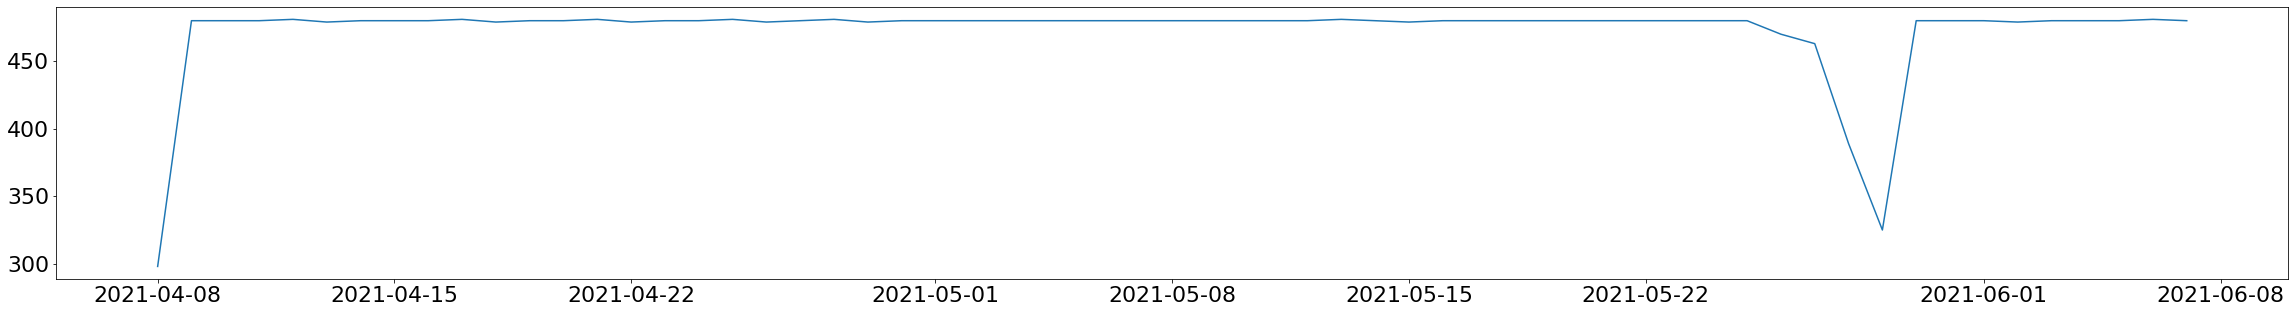

In [4]:
pd.Series([datetime.datetime.fromtimestamp(x).date() for idx,x in enumerate(list(packet_timestamps))]).value_counts().plot(figsize=(40,5))

In [5]:
new_all_data = []
new_packet_timestamps = []

for x,y in zip(*(all_data,packet_timestamps)):
    if datetime.datetime.fromtimestamp(y).date() < datetime.date(2021, 5, 22) or datetime.datetime.fromtimestamp(y).date() > datetime.date(2021, 6, 1):
        new_all_data.append(x)
        new_packet_timestamps.append(y)
        
new_all_data = np.array(new_all_data)
new_packet_timestamps = np.array(new_packet_timestamps)

<AxesSubplot:>

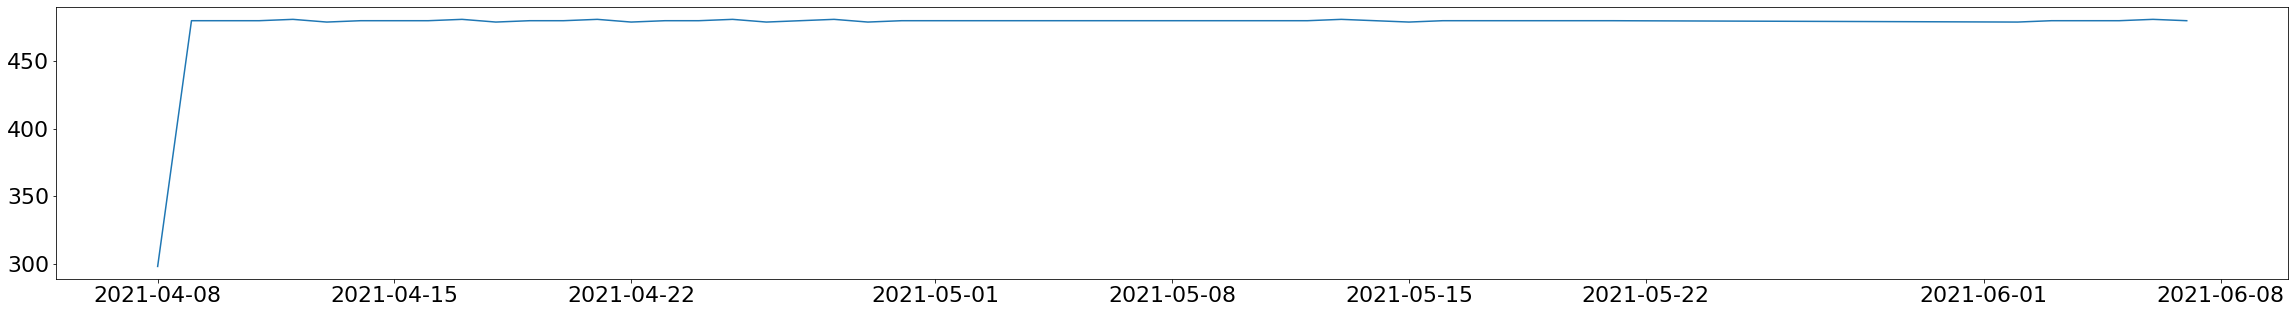

In [6]:
pd.Series([datetime.datetime.fromtimestamp(x).date() for idx,x in enumerate(new_packet_timestamps)]).value_counts().plot(figsize=(40,5))

<AxesSubplot:>

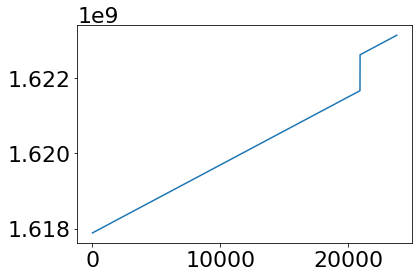

In [7]:
pd.Series(new_packet_timestamps).plot()

## Preparation for training

In [8]:
num_inst = new_all_data.shape[0]
train_end_percent = 0.7
test_start_percent = train_end_percent

train_end_idx =int(num_inst*train_end_percent)
test_start_idx = train_end_idx

print('Train end: ',train_end_idx)
print('Test start: ',test_start_idx)

train_data = new_all_data[:train_end_idx]
test_data = new_all_data[test_start_idx:]

print(train_data.shape,test_data.shape)

Train end:  16672
Test start:  16672
(16672, 80, 80) (7146, 80, 80)


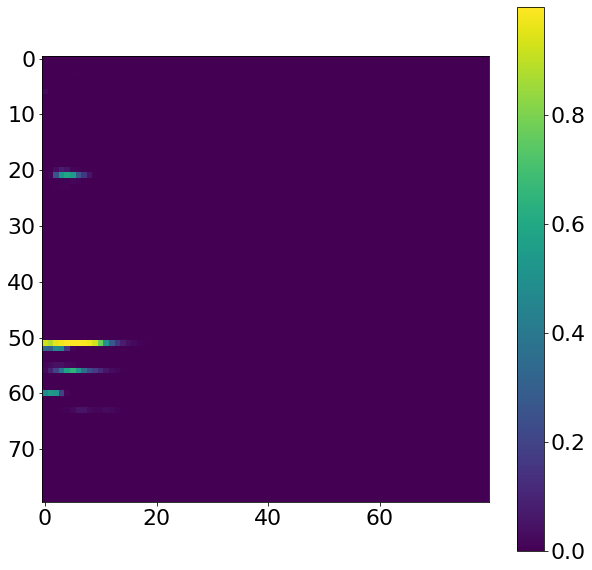

In [9]:
probsofpixels = np.zeros(train_data[0].shape)
for sig in train_data:
    for idxx,x in enumerate(sig):
        for idxy,y in enumerate(x):
            if y>0:
                probsofpixels[idxx,idxy] += 1
                
probsofpixels = probsofpixels/train_data.shape[0]

fig,ax = plt.subplots(1,1,figsize=(10,10))
im = ax.imshow(probsofpixels)
plt.colorbar(im,ax=ax)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


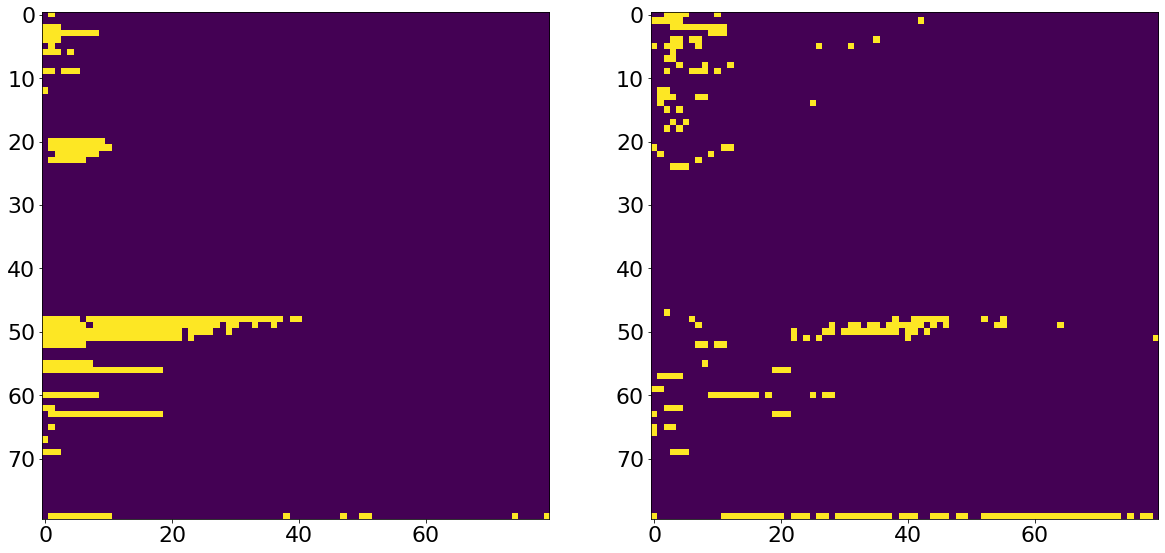

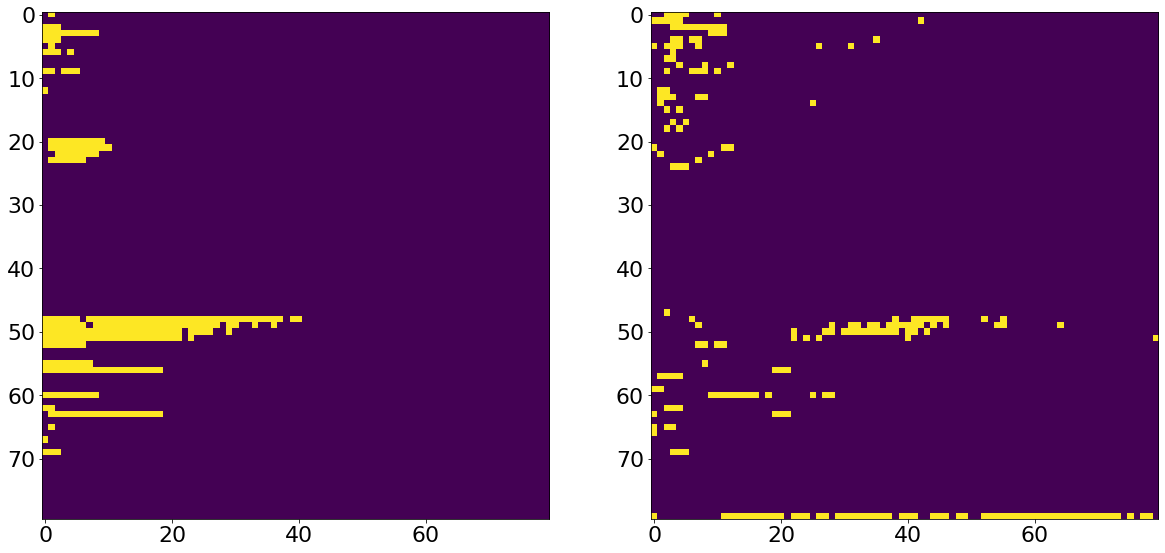

In [10]:
probpixbasedfilter = np.zeros(train_data[0].shape)
probpixbasedfilter_anom = np.zeros(train_data[0].shape)

for idxx,x in enumerate(probsofpixels):
    for idxy,y in enumerate(x):
        if probsofpixels[idxx,idxy]>0.0005:
            probpixbasedfilter[idxx,idxy] = 1
        if probsofpixels[idxx,idxy]<0.0005 and probsofpixels[idxx,idxy]>0:
            probpixbasedfilter_anom[idxx,idxy] = 1
        

fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(probpixbasedfilter)
ax[1].imshow(probpixbasedfilter_anom)

print(probpixbasedfilter[79,:])
probpixbasedfilter[79,:] = np.zeros(train_data[0,0].shape)
probpixbasedfilter[:,79] = np.zeros(train_data[0,0].shape)
print(probpixbasedfilter[79,:])

fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(probpixbasedfilter)
ax[1].imshow(probpixbasedfilter_anom)

In [11]:
probableanomalyindices = []
for idx,sig in enumerate(train_data):
    for idxx,x in enumerate(sig):
        for idxy,y in enumerate(x):
            if sig[idxx,idxy]>0 and probsofpixels[idxx,idxy]<0.0005:
                if idx not in probableanomalyindices:
                    probableanomalyindices.append(idx)

print('Length of train data',len(train_data))
print('Length of tagged anomalous data',len(probableanomalyindices))
print('Percent Probable anomalies:',100*len(probableanomalyindices)/len(train_data),'%')

Length of train data 16672
Length of tagged anomalous data 369
Percent Probable anomalies: 2.2132917466410746 %


In [12]:
## if discard data during cleaning
# cleantraindata = []
# for sig in train_data:
#     take = True
#     for idxx,x in enumerate(sig):
#         for idxy,y in enumerate(x):
#             if sig[idxx,idxy]>0 and probsofpixels[idxx,idxy]<0.03:
#                 take = False
#     if take:
#         cleantraindata.append(sig)

# print(len(cleantraindata))

# cleantraindata = np.array(cleantraindata)


## if retain data but mask during cleaning
cleantraindata = []
for sig in train_data:
    cleantraindata.append(np.multiply(sig,probpixbasedfilter))
print(len(cleantraindata))

cleantraindata = np.array(cleantraindata)

16672


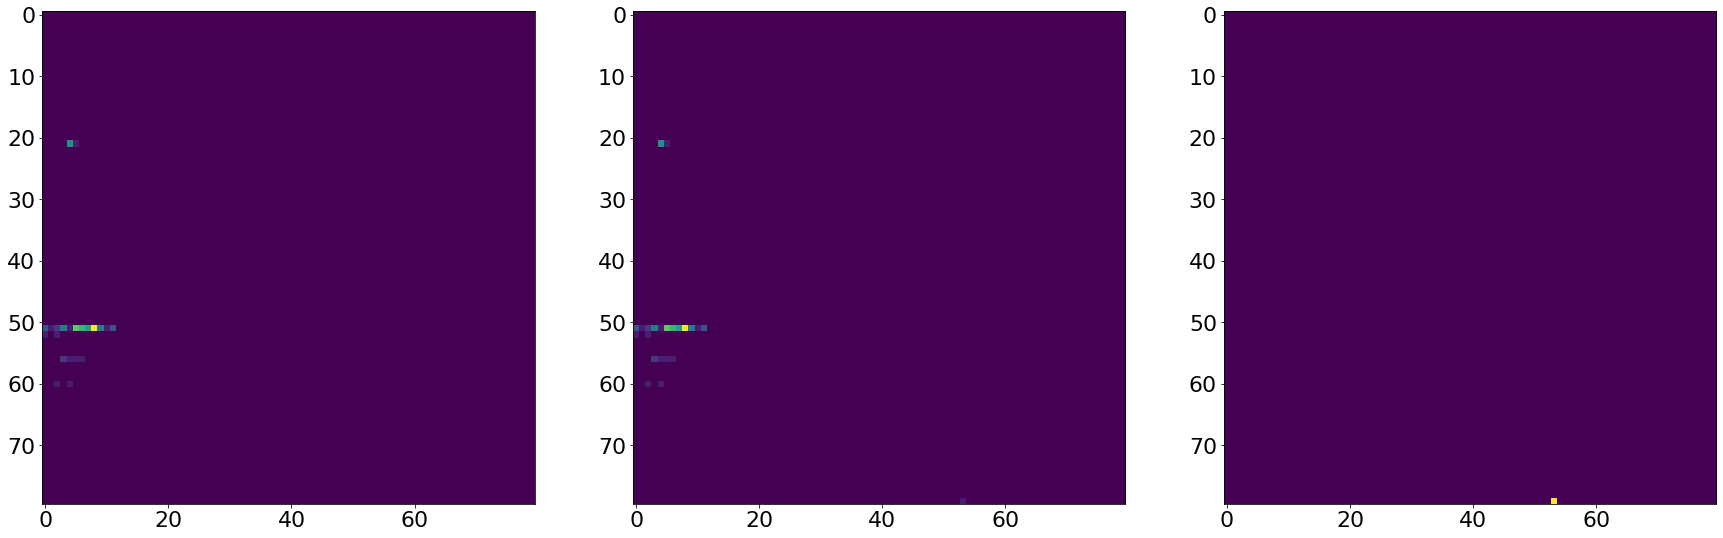

In [13]:
i = 1
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(cleantraindata[probableanomalyindices[i]])
ax[1].imshow(train_data[probableanomalyindices[i]])
ax[2].imshow(train_data[probableanomalyindices[i]]-cleantraindata[probableanomalyindices[i]])

In [14]:
num_train_inst = cleantraindata.shape[0]
val_start_percent = 0.7
train_end_idx =int(num_train_inst*val_start_percent)

clean_train_data = cleantraindata[:train_end_idx]
clean_val_data = cleantraindata[train_end_idx:]

print(clean_train_data.shape,clean_val_data.shape)

(11670, 80, 80) (5002, 80, 80)


In [15]:
#Min-Max Normalization (Values between [0,1])
max_counts_train = clean_train_data.max()
min_counts_train = clean_train_data.min()

train_data_norm = (clean_train_data - min_counts_train)/(max_counts_train - min_counts_train)
val_data_norm = (clean_val_data - min_counts_train)/(max_counts_train - min_counts_train)
test_data_norm = (test_data - min_counts_train)/(max_counts_train - min_counts_train)

In [16]:
train_data_norm = np.expand_dims(train_data_norm,axis=1)
test_data_norm = np.expand_dims(test_data_norm,axis=1)
val_data_norm = np.expand_dims(val_data_norm,axis=1)

In [17]:
# train_data_norm_2c = np.concatenate([train_data_norm[1:,:],train_data_norm[:-1,:]],axis=1)
# test_data_norm_2c = np.concatenate([test_data_norm[1:,:],test_data_norm[:-1,:]],axis=1)
# val_data_norm_2c = np.concatenate([val_data_norm[1:,:],val_data_norm[:-1,:]],axis=1)

In [ ]:
# np.save('/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/preprocessed_signatures_traintestval/fm/train_<p0001masked.npy',train_data_norm_2c)
# np.save('/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/preprocessed_signatures_traintestval/fm/tests_<p0001masked.npy',test_data_norm_2c)
# np.save('/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/preprocessed_signatures_traintestval/fm/val_<p0001masked.npy',val_data_norm_2c)

np.save('/home/rgopikrishna/data/noisereduced/train.npy',train_data_norm)
np.save('/home/rgopikrishna/data/noisereduced/test.npy',test_data_norm)
np.save('/home/rgopikrishna/data/noisereduced/val.npy',val_data_norm)

In [ ]:
np.save('/home/rgopikrishna/data/noisereduced/minmax.npy',np.array([min_counts_train,max_counts_train]))
# np.save('/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/preprocessed_signatures_traintestval/fm/minmax_150s.npy',np.array([min_counts_train,max_counts_train]))